# Road Lane Detection Using Hough Transform
Sohail Waleed Elganagy ID :7372

Hana Waleed Farouk ID: 7599

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
image_bgr= cv2.imread("road_image.png")

In [ ]:
image_bgr.shape

(574, 1047, 3)

In [ ]:
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

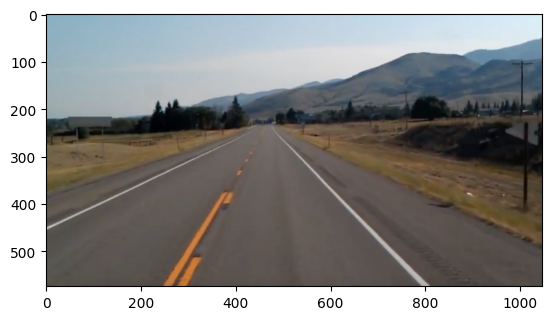

In [ ]:
plt.imshow(image_rgb)
plt.show()

In [ ]:
def polar_to_cartesian(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    return (x1, y1), (x2, y2)

## 1. Smoothing Image using Median Filter

In [ ]:
def smooth_image_built_in(image,kernel_size = 3):
    return cv2.medianBlur(image, kernel_size)


def smooth_image_custom(image,kernel_size=3):
    pad_size = kernel_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
    output_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighbors= padded_image[i:i+kernel_size, j:j+kernel_size]
            output_image[i, j] = np.median(neighbors)

    return output_image

In [ ]:
def smooth_image_custom(image, kernel_size=3):

    if len(image.shape) == 2:
        return apply_median_filter(image, kernel_size)
    elif len(image.shape) == 3:
        channels = cv2.split(image)
        smoothed_channels = [apply_median_filter(channel, kernel_size) for channel in channels]
        return cv2.merge(smoothed_channels)

def apply_median_filter(channel, kernel_size=3):
    pad_size = kernel_size // 2
    padded_image = np.pad(channel, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
    output_image = np.zeros_like(channel)

    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            neighbors = padded_image[i:i+kernel_size, j:j+kernel_size]
            output_image[i, j] = np.median(neighbors)

    return output_image

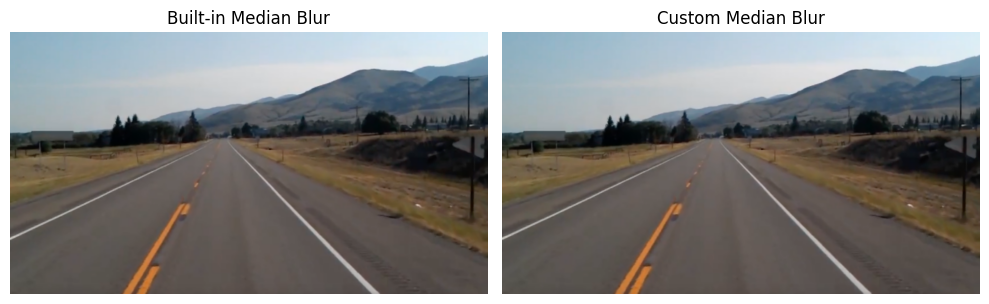

In [ ]:
smoothed_builtin = smooth_image_built_in(image_bgr, kernel_size=3)
smoothed_custom = smooth_image_custom(image_bgr, kernel_size=3)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(smoothed_builtin, cv2.COLOR_BGR2RGB))
plt.title('Built-in Median Blur')
plt.axis('off')

plt.subplot(1, 2,2)
plt.imshow(cv2.cvtColor(smoothed_custom, cv2.COLOR_BGR2RGB))
plt.title('Custom Median Blur')
plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Edge Detection using Canny Filter
Canny Filter only works on greyscale images


In [ ]:
def canny_filter(image,low_threshold=50,high_threshold=150):
    return cv2.Canny(image,low_threshold,high_threshold)

In [ ]:
image_gray = cv2.cvtColor(smoothed_builtin, cv2.COLOR_BGR2GRAY)

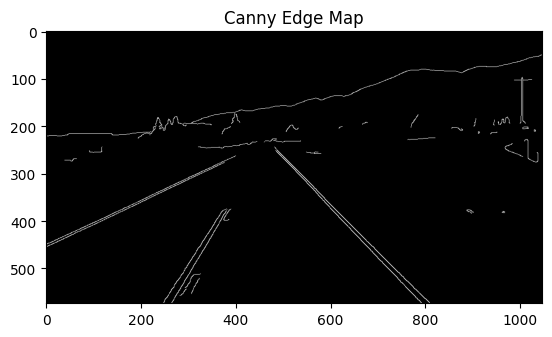

In [ ]:
edge_map = canny_filter(image_gray,100,200)
plt.imshow(edge_map,cmap='gray')
plt.title('Canny Edge Map')
plt.show()

## 3. Region of Interest
Assume that road is always bottom center of the image

In [ ]:
def get_polygon_mask(width,height):
    bottom_left = (int(width * 0), height)
    top_left = (int(width * 0), int(height * 0.4))
    top_right = (int(width * 0.7), int(height * 0.4))
    bottom_right = (int(width * 0.8), height)

    polygon = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [polygon], 255)

    return mask

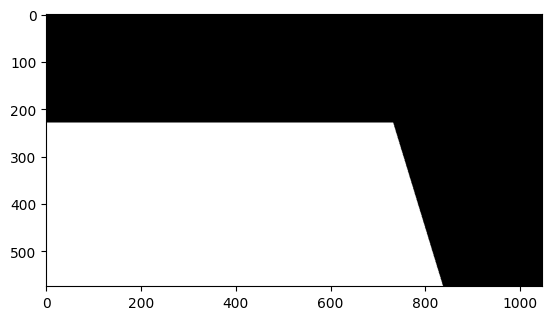

In [ ]:
mask = get_polygon_mask(edge_map.shape[1], edge_map.shape[0])
plt.imshow(mask,cmap='gray')
plt.show()

In [ ]:
def apply_mask(edges, mask):
    return cv2.bitwise_and(edges, mask)

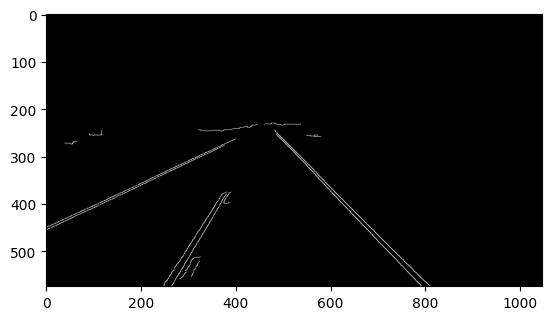

In [ ]:
masked_edges = apply_mask(edge_map, mask)
plt.imshow(masked_edges,cmap='gray')
plt.show()

## 4. Hough Transform

In [ ]:
def calculate_hough_accumulator(edge_image, num_rhos=180, num_thetas=180):
    #num rhos is number of bins
    height, width = edge_image.shape
    max_dist = int(np.sqrt(height**2 + width**2))

    #param space

    thetas = np.deg2rad(np.linspace(0, 180, num_thetas))
    rhos = np.linspace(-max_dist, max_dist, num_rhos)
    accumulator = np.zeros((num_rhos, num_thetas), dtype=np.int32)
    # needed to be reused multiple time , pre-compute
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    for y in range(height):
        for x in range(width):
            if edge_image[y, x]:
                for theta_idx in range(num_thetas):
                    rho = x * cos_thetas[theta_idx] + y * sin_thetas[theta_idx]
                    rho_idx = int(np.round((rho + max_dist) * (num_rhos / (2 * max_dist)))) # choose which bin
                    accumulator[rho_idx, theta_idx] += 1

    return accumulator, rhos, thetas


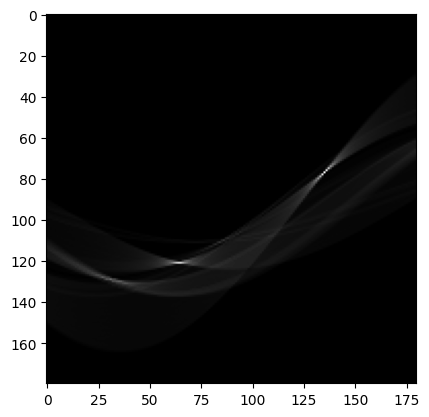

In [ ]:
accumulator,rhos,thetas= calculate_hough_accumulator(masked_edges)
plt.imshow(accumulator, cmap='gray')

In [ ]:
def find_best_lines(accumulator, rhos, thetas, threshold=400):
    y_indices, x_indices = np.where(accumulator > threshold)
    best_lines = []

    for i in range(len(y_indices)):
        rho = rhos[y_indices[i]]
        theta = thetas[x_indices[i]]
        best_lines.append((rho, theta))

    return best_lines

In [ ]:
best_lines = find_best_lines(accumulator,rhos,thetas)

In [ ]:
def create_line_mask(img, lines, line_thickness=2):
    line_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    for rho, theta in lines:
        (x1, y1), (x2, y2) = polar_to_cartesian(rho, theta)
        cv2.line(line_mask, (x1, y1), (x2, y2), (255, 255, 255), line_thickness)

    return line_mask

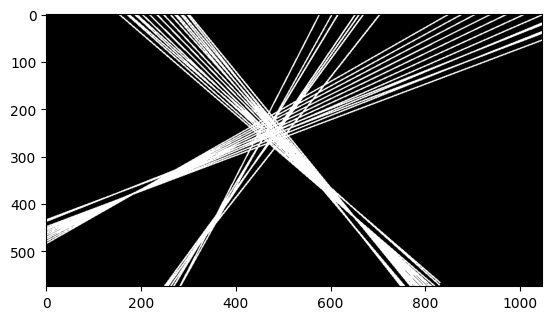

In [ ]:
line_mask = create_line_mask(smoothed_builtin, best_lines)
plt.imshow(line_mask,cmap='gray')
plt.show()

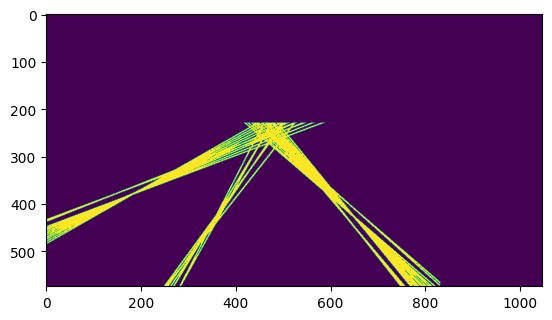

In [ ]:
line_mask = apply_mask(line_mask, mask)
plt.imshow(line_mask)
plt.show()

In [ ]:
def plot_hough_lines(img, mask):
    if len(img.shape) == 2:  # Grayscale image
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to BGR

    overlayed_image = img.copy()

    overlayed_image[mask == 255] = [0, 255, 0]

    return cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)



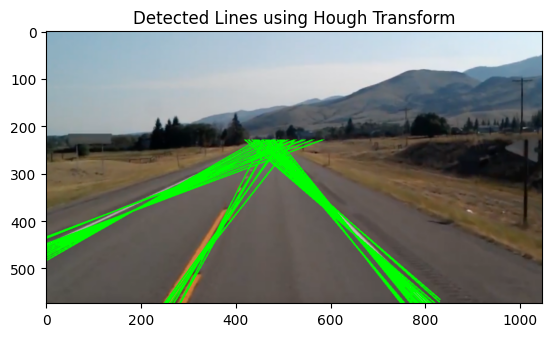

In [ ]:
detected_line_image = plot_hough_lines(smoothed_builtin, line_mask)
plt.imshow(detected_line_image)
plt.title("Detected Lines using Hough Transform")
plt.show()

## 5. Non Maximum Supression

In [ ]:
def non_maximum_suppression(accumulator, threshold =400):
    suppressed_accumulator = np.zeros_like(accumulator)

    height, width = accumulator.shape

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if accumulator[i, j] > threshold:
                neighbors = accumulator[i-1:i+2, j-1:j+2]
                if accumulator[i, j] >= np.max(neighbors):
                    suppressed_accumulator[i, j] = accumulator[i, j]

    return suppressed_accumulator

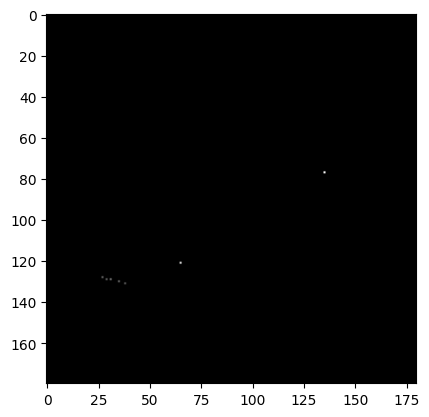

In [ ]:
suppressed_accumulator= non_maximum_suppression(accumulator)
plt.imshow(suppressed_accumulator, cmap='gray')

In [ ]:
best_lines_suppressed = find_best_lines(suppressed_accumulator,rhos,thetas)

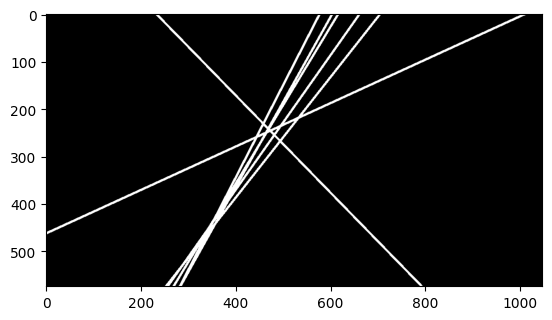

In [ ]:
supressed_line_mask = create_line_mask(smoothed_builtin, best_lines_suppressed,line_thickness=4)
plt.imshow(supressed_line_mask,cmap='gray')
plt.show()

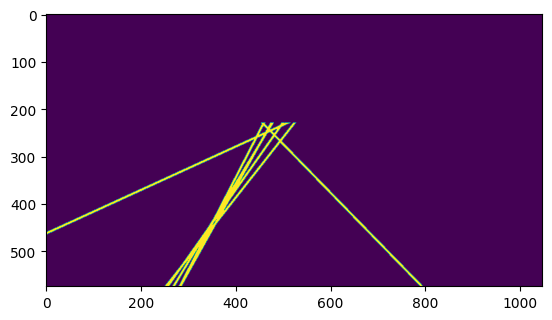

In [ ]:
supressed_line_mask = apply_mask(supressed_line_mask, mask)
plt.imshow(supressed_line_mask)
plt.show()

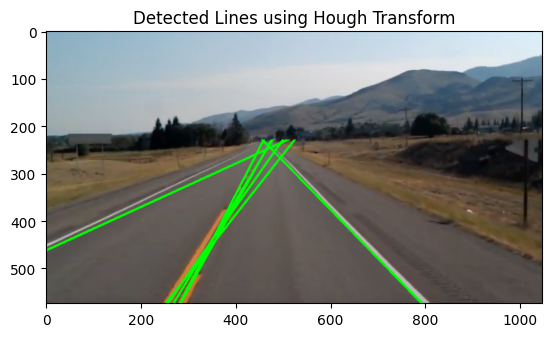

In [ ]:
detected_line_image_supressed = plot_hough_lines(smoothed_builtin, supressed_line_mask)
plt.imshow(detected_line_image_supressed)
plt.title("Detected Lines using Hough Transform")
plt.show()

In [ ]:
def get_road_lanes(bgr_img,canny_threshold_1 = 100, canny_threshold_2 = 200,accumulator_threshold = 400):
  smoothed_image = smooth_image_built_in(bgr_img, kernel_size=3)
  edge_map = canny_filter(cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2GRAY),canny_threshold_1,canny_threshold_2)
  mask = get_polygon_mask(edge_map.shape[1], edge_map.shape[0])
  masked_edges = apply_mask(edge_map, mask)
  accumulator,rhos,thetas= calculate_hough_accumulator(masked_edges,accumulator_threshold)
  suppressed_accumulator= non_maximum_suppression(accumulator, accumulator_threshold)
  best_lines_suppressed = find_best_lines(suppressed_accumulator,rhos,thetas)
  supressed_line_mask = create_line_mask(smoothed_image, best_lines_suppressed,line_thickness=4)
  supressed_line_mask = apply_mask(supressed_line_mask, mask)
  detected_line_image_supressed = plot_hough_lines(smoothed_image, supressed_line_mask)
  return detected_line_image_supressed


## Test Images

In [ ]:
image_bgr = cv2.imread("road_image.png")

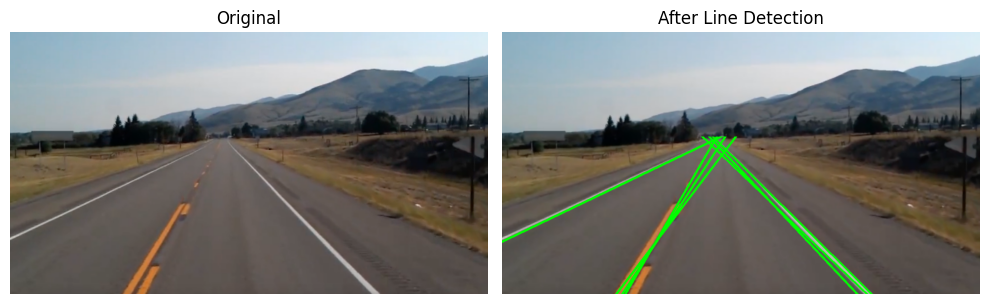

In [ ]:
detected_line_image = get_road_lanes(image_bgr,accumulator_threshold = 200)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2,2)
plt.imshow(detected_line_image)
plt.title('After Line Detection')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
image_bgr = cv2.imread("road2.png")

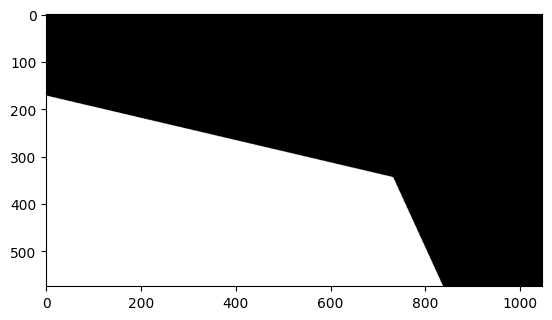

In [ ]:
def get_polygon_mask(width,height):
    bottom_left = (int(width * 0), height)
    top_left = (int(width * 0), int(height * 0.3))
    top_right = (int(width * 0.7), int(height * 0.6))
    bottom_right = (int(width * 0.8), height)

    polygon = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [polygon], 255)

    return mask

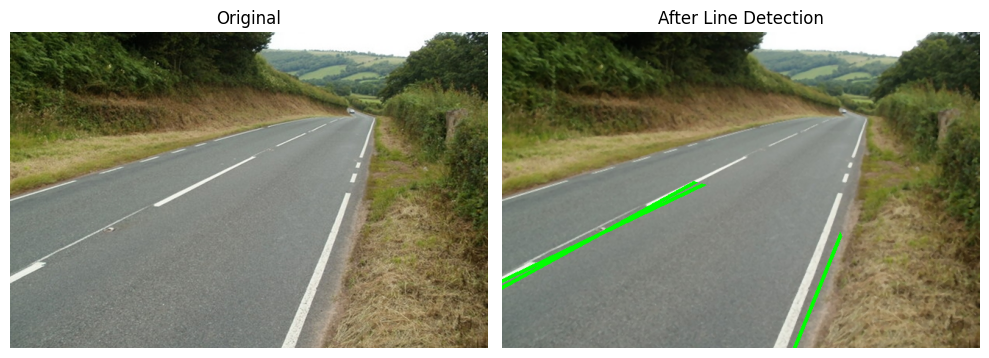

In [ ]:
detected_line_image = get_road_lanes(image_bgr,accumulator_threshold = 70)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2,2)
plt.imshow(detected_line_image)
plt.title('After Line Detection')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
image_bgr = cv2.imread("road3.png")

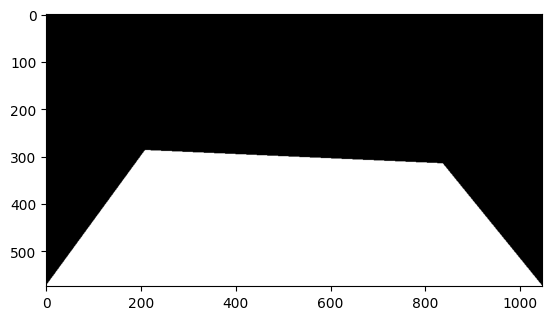

In [ ]:
def get_polygon_mask(width,height):
    bottom_left = (int(width * 1), height)
    top_left = (int(width * 0.8), int(height * 0.55))
    top_right = (int(width * 0.2), int(height * 0.5))
    bottom_right = (int(width * 0), height)

    polygon = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [polygon], 255)

    return mask

mask = get_polygon_mask(edge_map.shape[1], edge_map.shape[0])
plt.imshow(mask,cmap='gray')
plt.show()

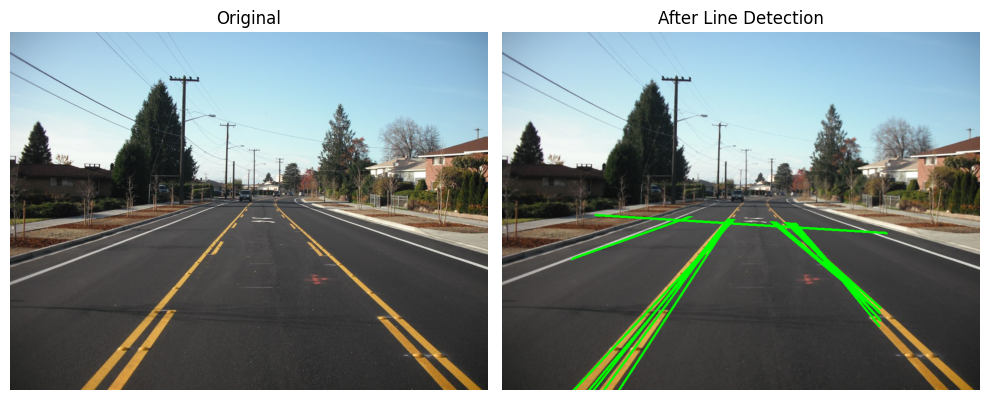

In [ ]:
detected_line_image = get_road_lanes(image_bgr,accumulator_threshold = 300)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2,2)
plt.imshow(detected_line_image)
plt.title('After Line Detection')
plt.axis('off')

plt.tight_layout()
plt.show()